# 自動運転サンプル

道路の白線を認識し、白線に沿って走行するサンプルです。

シミュレータコースの条件は以下の通りです。
- 道路の両側が白線であること
- 交差点などがないこと
- 急なカーブがないこと
- 円となっていること
- 車の初期位置がコース内であること

## コースイメージ

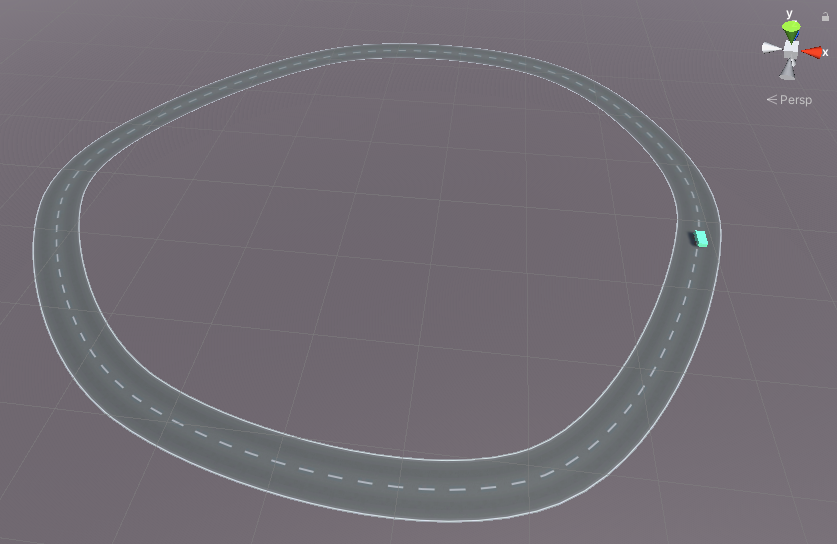


## 車の初期位置

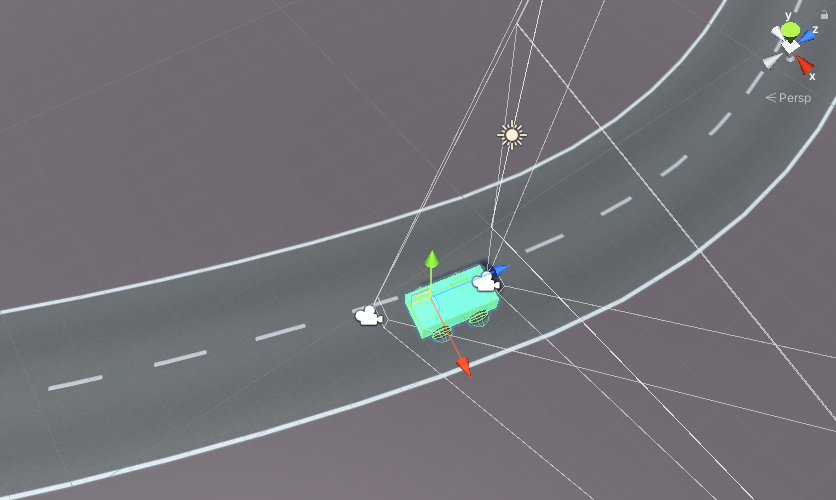

In [1]:
import cv2, mmap, io
import numpy as np
from PIL import Image
import traceback
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime
import pandas as pd
import time

import socket_utils, controal, camera

In [2]:
# 画像変換用関数
def pil2cv(image):
    """
    convert PIL to cv

    Parameters
    ----------
    image : PIL image
        PIL image.

    Returns
    -------
    new_image : cv mat
        cv mat.
    """
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  
        pass
    elif new_image.shape[2] == 3:  
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

## 条件設定

条件設定を行います。

うまく走行してくれない場合は、制御用パラメータ設定を調整します。

◆調整例

- カーブが曲がり切れない場合
  - 巡行速度、減速時の巡行速度を落とす
  - ステアリング制御用パラメータを増やす
- 走行時に振動する場合
  - ステアリング制御用パラメータを減らす
- 安定しているが遅い場合
  - 巡行速度をあげる

In [3]:
###### 実験条件設定 ######   
# フレームサイズ(リサイズ後の値を指定)
W = 640
H = 360
# フレームレート
frame_rate = 20.0

# 映像を保存するか
save_video = False
# 結果を保存するか
save_result = False

# 物体検出を行うかどうか
# 物体検出をするにはPyTorchのインストールが必要
obj_detection = False
if obj_detection:
    import torch
    model = torch.hub.load('ultralytics/yolov3', 'yolov3')
    classes = model.names
    
###### 制御用パラメータ設定 ######
# ステアリング制御用パラメータ
st_pid_param = [0.80, 0.00, 0.50]
# ステアリング最大角度
max_st = 2
# ステアリング閾値（これを超えると減速）
st_th = 0.3

# 巡行速度
max_v = 6
# 減速時の巡行速度
min_v = 3

###### Unityパラメータ設定 ######
# mmapカメラのtagname
# Unity側で設定したものを使用してください。
tagname = "Flont"

# ポート番号
# Unity側で設定したものを使用してください。
udp_send_port=9000
udp_recv_port=9001
tcp_send_port=9100

In [4]:
windowName = "video"
result = {}
result["u"] = []
result["p"] = []
result["i"] = []
result["d"] = []
result["x"] = []
result["y"] = []
result["v"] = []
frame_num = 0
size = (int(W*2), H)
dt_now = datetime.datetime.now()
dt_str = dt_now.strftime('%Y%m%d%H%M%S')
if save_video:
    codec = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter('./result/{}.mp4'.format(dt_str), codec, 
                             frame_rate, (int(W*2), H))

# 自動運転開始

自動運転を開始します。Unityシミュレータを起動後、下のセルを実行してください。Unityシミュレータを起動していない場合は実行に失敗します。



In [6]:
# initialize detector and controler
line_detector = controal.LineDetector([W, H], drow_img=False)
carcontroal = controal.CarControal([W, H], st_param=st_pid_param, max_v=max_v, max_st=max_st,
                                   st_th=st_th, min_v=min_v,
                                   udp_send_port=udp_send_port, udp_recv_port=udp_recv_port)
# start recive data
carcontroal.update_th_start()

try:
    img = np.zeros((W, H, 3))
    cv2.imshow(windowName, img)
    # prerare mmap camera
    mm = camera.MMAPCamera(tagname=tagname)
    while cv2.getWindowProperty(windowName, cv2.WND_PROP_VISIBLE) > 0:
        # read image  
        ByteToImg = mm.read()
        try:
            img = pil2cv(ByteToImg)
        except:
            print("failed")
            continue
        # resize
        img = cv2.resize(img, (W, H))

        # object detection
        if obj_detection:
            if frame_num % 2 == 0:
                results = model(img).xyxy[0].to('cpu').detach().numpy().copy()
            frame_num += 1

        # detect white line
        x, y, img_thresh = line_detector.detect_line(img)
        # controal car using white line 
        u, p_val, i_val, d_val = carcontroal.controal(x, y)

        # save result
        result["u"].append(u)
        result["p"].append(p_val)
        result["i"].append(i_val)
        result["d"].append(d_val)
        result["x"].append(x-W/2)
        result["y"].append(y)
        result["v"].append(carcontroal.v)
        if carcontroal.time != 0:
            raise Exception

        # drow the result of object detection
        if obj_detection:
            for r in results:
                cv2.rectangle(img, (int(r[0]), int(r[1])), (int(r[2]), int(r[3])), (255, 0, 0))
        # show image
        img_thresh = cv2.cvtColor(img_thresh, cv2.COLOR_GRAY2BGRA)
        img = cv2.hconcat([img, img_thresh])
        cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        if save_video:
            writer.write(img)
        cv2.imshow(windowName, img)
        if cv2.waitKey(1)&0xFF == ord('q'):
            break
except:
    print(traceback.format_exc())
    cv2.destroyAllWindows()     

if save_result:
    df = pd.io.json.json_normalize(result)
    df.to_csv('./result/{}_data.csv'.format(dt_str), index=False)
    s = "time:{}\n".format(carcontroal.time)
    s += "param:{}\n".format(param)
    with open("./result/{}_result.txt".format(dt_str), "w") as f:
        f.write(s)

# シミュレーション終了後、resetシグナルを送信
try:
    s1 = socket_utils.TCPboth(tcp_send_port+1)
    s1.create_connection(tcp_send_port)
    s1.send("reset")
except:
    pass
finally:
    try:
        s1.close()
    except:
        pass

# reset完了を待機
while carcontroal.time != 0:
    time.sleep(0.1)
    print("waiting...")
carcontroal.destroy()
mm.destroy()
del mm, carcontroal
if save_video:
    writer.release()

send OK
OK


## 結果確認

結果をプロットします。

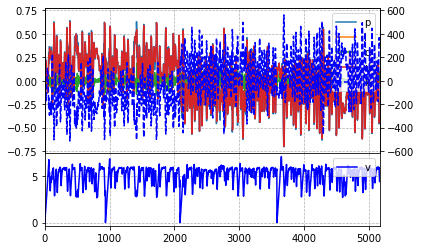

In [19]:
# プロット
fig = plt.figure()
# 縦に3分割する
gs = gridspec.GridSpec(3,1)
# そのうち上2つを上のグラフに
ax1 = plt.subplot(gs[:2])
ax2 = ax1.twinx() # y軸を追加

# 残り1つを下のグラフに
ax3 = plt.subplot(gs[2], sharex=ax1)
# 残り1つを下のグラフに
ax3 = plt.subplot(gs[2], sharex=ax1) # 上のグラフとx軸のスケールは共通
ax1.plot(result["p"], label="p")
ax1.plot(result["i"], label="i")
ax1.plot(result["d"], label="d")
ax1.plot(result["u"], label="u")
ax1.grid(linestyle='--', linewidth=0.7)

ax2.plot(result["x"], "b--", label="x")
tmp = max(abs(max(result["p"])), abs(min(result["p"])))
tmp = max(max(abs(max(result["i"])), abs(min(result["i"]))), tmp)
tmp = max(max(abs(max(result["d"])), abs(min(result["d"]))), tmp)
tmp = max(max(abs(max(result["u"])), abs(min(result["u"]))), tmp)
ax1.set_ylim(tmp*(-1.1), tmp*1.1)
tmp = max(abs(max(result["x"])), abs(min(result["x"])))
ax2.set_ylim(tmp*(-1.1), tmp*1.1)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(result["v"], "b-", label="v")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')
ax3.legend(loc='upper right')

ax3.grid(linestyle='--', linewidth=0.7)
plt.xlim(0,len(result["x"]))
plt.subplots_adjust(hspace=.0)
if save_result:
    plt.savefig("{}_grarh.png".format(dt_str), format="png", dpi=300)
plt.show()        